**OVERVIEW**

**Objective**

You are given a dataset from Zalando, a European e-commerce app. The dataset has several missing values. The aim of this project is to appropriately handle missing values in a real-world environment. 

**Explanation**

The majority of missing values in tech companies arise from the fact that it was the user's choice: 
1. by not filling out her profile, or
2. by changing her privacy settings, or 
3. by deleting her cookies. 

**Drawbacks of standard approaches for handling missing data**

Approach: Removal of rows containing missing values

Drawback: this distorts the predictive model due to loss of information.

Approach: Replacement of missing values with a distribution similar to the non-missing values

Drawback: this distorts the predictive model due to modification of information.

**Solution**

There is a lot of information in the fact that the user has chosen to not do something. We don't want to lose that information.

The best way to deal with missing values is to encode them as such:

1. If it is a categorical variable: create a new level “missing”.
2. If it is a continuous variable, replace the missing value with a very large/small number, clearly outside the range of the variable, i.e. >=10^9

Then, use a model which is not affected by outliers, such as Random Forests

**INITIALISATION**

**Import libraries and modules**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

**Setup environment**

In [ ]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

**Read dataset**

This dataset consists of records of 120,704 user sessions on an e-commerce site. 

Columns:

1. country: user country; user-provided; non-mandatory; values: France, UK, Ireland, NA; if missing, it means users did not fill it out
2. age: user age; mandatory
3. is_mobile: whether the user visited the site via mobile app (1) or desktop (0)
4. source : marketing channel source; values: "Ads", "Direct", "Seo"
5. converted: label, 1 means they converted within the session, 0 means they left without buying anything. 

The goal is to increase conversion rate: # conversions / total sessions



In [ ]:
data = pd.read_csv("https://drive.google.com/uc?export=download&id=1TC0m9YsNwTuj7UFyI5M02k7V0nGgh0tZ")

print(data.head())

   country  age  is_mobile  source  converted
0       UK   33          0  Direct          0
1      NaN   38          1     Seo          0
2      NaN   46          0     Ads          0
3      NaN   48          1     Seo          0
4  Ireland   53          0     Ads          0


**ANALYSIS**

**Get dataset stats**

In [ ]:
rcParams.update({'figure.autolayout': True})
  
print(data.describe(include='all'))

       country            age      is_mobile  source      converted
count    95502  120704.000000  120704.000000  120704  120704.000000
unique       3            NaN            NaN       3            NaN
top         UK            NaN            NaN     Seo            NaN
freq     69626            NaN            NaN   59324            NaN
mean       NaN      44.575258       0.631006     NaN       0.169845
std        NaN      11.661944       0.482534     NaN       0.375498
min        NaN      17.000000       0.000000     NaN       0.000000
25%        NaN      36.000000       0.000000     NaN       0.000000
50%        NaN      44.000000       1.000000     NaN       0.000000
75%        NaN      53.000000       1.000000     NaN       0.000000
max        NaN      80.000000       1.000000     NaN       1.000000


**Get conversion rates of "missing" vs non-missing countries**

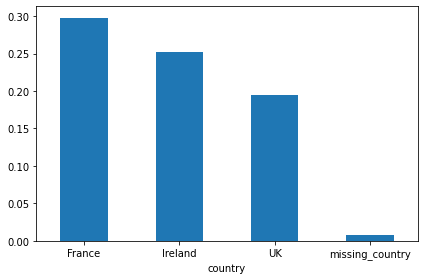

In [ ]:
data.fillna("missing_country").groupby(['country'])['converted'].mean().plot.bar()
plt.xticks(rotation=0)
plt.show()

**Important insight**:

When there are missing values, the main metrics for those users tend to be much worse compared to the other users. This is *self-selection bias*. The least engaged users are usually those who choose to not provide certain information about themselves.

**BUILD MODEL**

Build a model to predict conversion rate and see how different strategies work. 

First, try to replace missing values with values sampled with replacement from that variable.

Sampling is a good strategy because it gives higher weight to values that show up the most in the original data.

In [ ]:
np.random.seed(4684)

data_replace = data.copy()

**Split test-train**

In [ ]:
train, test = train_test_split(data_replace, test_size = 0.34)
train

,country,age,is_mobile,source,converted
1747,UK,53,0,Direct,0
4142,UK,29,1,Seo,0
45290,UK,34,1,Seo,0
38305,UK,61,0,Ads,0
37960,NaN,36,1,Direct,0
...,...,...,...,...,...
116771,France,55,1,Seo,1
106887,UK,37,0,Ads,1
46011,NaN,66,1,Ads,0
111529,Ireland,42,0,Ads,1


In [ ]:
train = train.reset_index(drop=True).copy()
test = test.reset_index(drop=True).copy()

**Replace NAs with randomly selected countries, as per original country distribution**

In [ ]:
train_country_distribution = pd.Series(np.random.choice( train['country'].dropna() , size=len(train['country']) ))
test_country_distribution = pd.Series(np.random.choice( test['country'].dropna() , size=len(test['country']) ))

train['country'] = train['country'].fillna(train_country_distribution)
test['country'] = test['country'].fillna(test_country_distribution)

**Create indicators for train & test**

In [ ]:
train = pd.get_dummies(train, drop_first=True)
test =  pd.get_dummies(test, drop_first=True)

**Build model**

In [ ]:
rf_replace_sampling = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_replace_sampling.fit(train.drop('converted', axis=1), train['converted'])

RandomForestClassifier(class_weight={0: 1, 1: 5}, n_estimators=50,
                       oob_score=True)

**Print confusion matrix**

In [ ]:
conf_matrix = confusion_matrix(test['converted'], rf_replace_sampling.predict(test.drop('converted', axis=1)), labels=[0, 1])
conf_matrix_sampling = pd.DataFrame(conf_matrix)
print(conf_matrix_sampling)

       0      1
0  23926  10233
1   2040   4841


**Get accuracy, FPR, FNR**

In [ ]:
true_negatives = conf_matrix_sampling.loc[0,0]
false_positives = conf_matrix_sampling.loc[0,1]
true_positives = conf_matrix_sampling.loc[1,1]
false_negatives = conf_matrix_sampling.loc[1,0]

base_accuracy = rf_replace_sampling.score(test.drop('converted', axis=1), test['converted'])
base_fpr = false_positives / (true_negatives + false_positives)
base_fnr = false_negatives / (false_negatives + true_positives)

print(pd.DataFrame({
                      'accuracy': base_accuracy,
                      'false_positive_rate' :[base_fpr],
                      'false_negative_rate' :[base_fnr]
                    }))

   accuracy  false_positive_rate  false_negative_rate
0   0.70095              0.29957             0.296469


**Get feature importance**

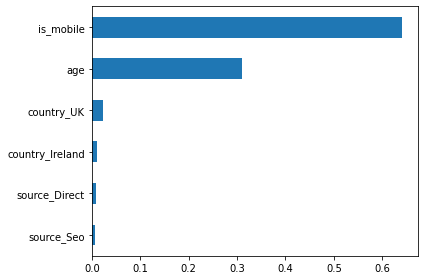

In [ ]:
pd.Series(rf_replace_sampling.feature_importances_, index=train.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')
plt.show()

**Replace missing values with "missing country"**

In [ ]:
data['country'] = data['country'].fillna("missing_country")
data = pd.get_dummies(data, drop_first=True)
train_with_missing, test_with_missing = train_test_split(data, test_size = 0.34)

**Build RF**

In [ ]:
rf_with_missing = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_with_missing.fit(train_with_missing.drop('converted', axis=1), train_with_missing['converted'])

predicted = rf_with_missing.predict(test_with_missing.drop('converted', axis=1))
conf_matrix_with_missing = pd.DataFrame(confusion_matrix(test_with_missing['converted'], predicted, labels=[0, 1]))
conf_matrix_with_missing

,0,1
0,25300,8680
1,1954,5106


**Get updated accuracy, FPR, FNR**

In [ ]:
true_negatives = conf_matrix_with_missing.loc[0,0]
false_positives = conf_matrix_with_missing.loc[0,1]
true_positives = conf_matrix_with_missing.loc[1,1]
false_negatives = conf_matrix_with_missing.loc[1,0]

accuracy_with_missing = rf_with_missing.score(test_with_missing.drop('converted', axis=1),test_with_missing['converted'])
fpr_with_missing = false_positives / (true_negatives + false_positives)
fnr_with_missing = false_negatives / (false_negatives + true_positives)


print(pd.DataFrame( {'accuracy_with_missing': accuracy_with_missing,
                         'fpr_with_missing' :[fpr_with_missing],
                         'fnr_with_missing' :[fnr_with_missing]
}))

   accuracy_with_missing  fpr_with_missing  fnr_with_missing
0               0.740887          0.255444          0.276771


**Improvement**

In [ ]:
accuracy_improvement = accuracy_with_missing - base_accuracy
fpr_improvement = base_fpr - fpr_with_missing
fnr_improvement = base_fnr - fnr_with_missing

print(pd.DataFrame( {'accuracy_improvement': accuracy_improvement,
                         'fpr_improvement' :[fpr_improvement],
                         'fnr_improvement' :[fnr_improvement]
}))

   accuracy_improvement  fpr_improvement  fnr_improvement
0              0.039937         0.044125         0.019698


**Get updated feature importance**

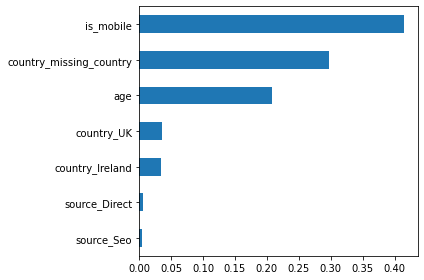

In [ ]:
pd.Series(rf_with_missing.feature_importances_, index=train_with_missing.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')
plt.show()